In [305]:
# Libraries
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load private loan PD values from CSV
print("Loading Private_PD.csv...")
private_pd_df = pd.read_csv('Private_PD.csv')
private_PD = private_pd_df['PD'].values
print(f"Loaded {len(private_PD)} PD values for personal loans.\n")
# Fixed parameters
n_assets = 150
n_simulations = 1000
rho = 0.39

# Lending amount (total portfolio)
total_lending_amount = 50000000

Loading Private_PD.csv...
Loaded 150 PD values for personal loans.



In [306]:
# Randomly assigning personal (0) and business (1) loans
loan_types = np.random.choice([0, 1], n_assets, p=[0.7, 0.3])  # assuming 70% personal and 30% business
print(f"Assigned {np.sum(loan_types == 0)} personal loans and {np.sum(loan_types == 1)} business loans.\n")
# Adjust PD for personal loans
n_personal_loans = np.sum(loan_types == 0)
n_business_loans = n_assets - n_personal_loans

# Generate random PD for business loans
business_PD = np.random.uniform(0.0001, 0.30, n_business_loans)
print(f"Generated PD values for {n_business_loans} business loans.\n")

# Combine PD values
PD = np.zeros(n_assets)
PD[loan_types == 0] = np.random.choice(private_PD, n_personal_loans, replace=True)
PD[loan_types == 1] = business_PD
print("Combined PD values for personal and business loans.\n")

# Modify loan amounts to sum up to total_lending_amount
loan_amounts = np.zeros(n_assets)
# Proportionally scale loan amounts
loan_amounts[loan_types == 0] = np.random.choice([50000, 25000, 10000], n_personal_loans, p=[0.4, 0.4, 0.2])
loan_amounts[loan_types == 1] = np.random.choice([300000, 200000, 100000], n_business_loans, p=[0.4, 0.4, 0.2])
# Adjust for the total lending amount
scaling_factor = total_lending_amount / np.sum(loan_amounts)
loan_amounts *= scaling_factor

Assigned 97 personal loans and 53 business loans.

Generated PD values for 53 business loans.

Combined PD values for personal and business loans.



In [307]:
# Initialize loan amounts and LGD
loan_amounts = np.zeros(n_assets)
LGD = np.zeros(n_assets)
print("The average personal loan probability of default is: {:.2%}".format(np.mean(business_PD)))
print("The average business loan probability of default is: {:.2%} \n".format(np.mean(private_PD)))

# Assign loan amounts and LGD based on PD and loan type
for i in range(n_assets):
    if loan_types[i] == 0:  # Personal loan
        LGD[i] = 1
        if PD[i] < 0.25:
            loan_amounts[i] = 11500
        else:
            loan_amounts[i] = 0
    else:  # Business loan
        if PD[i] < 0.0001:
            loan_amounts[i] = 600000
            LGD[i] = 0.25
        elif PD[i] < 0.0007:
            loan_amounts[i] = 450000
            LGD[i] = 0.25
        elif PD[i] < 0.0019:
            loan_amounts[i] = 300000
            LGD[i] = 0.4
        elif PD[i] < 0.0536:
            loan_amounts[i] = 100000
            LGD[i] = 0.4
        elif PD[i] < 0.2523:
            loan_amounts[i] = 25000
            LGD[i] = 0.55
        else:
            loan_amounts[i] = 0
            LGD[i] = 0.55
print("Assigned loan amounts and LGD values based on PD and loan type.\n")

The average personal loan probability of default is: 16.00%
The average business loan probability of default is: 6.92% 

Assigned loan amounts and LGD values based on PD and loan type.



In [308]:
# Losses
losses_personal = np.zeros(n_simulations)
losses_business = np.zeros(n_simulations)

# Vasicek parameters
Y = np.random.normal(0, 1, n_simulations)
Z = np.random.normal(0, 1, (n_simulations, n_assets))

# Loss simulation
for i in range(n_simulations):
    X = (np.sqrt(rho**2) * Y[i]) + (np.sqrt(1 - rho**2) * Z[i])
    default_events = X < [norm.ppf(pd) for pd in PD]
    loss_personal = np.sum(default_events[loan_types == 0] * LGD[loan_types == 0] * loan_amounts[loan_types == 0])
    loss_business = np.sum(default_events[loan_types == 1] * LGD[loan_types == 1] * loan_amounts[loan_types == 1])
    losses_personal[i] = loss_personal
    losses_business[i] = loss_business

print("Loss simulation complete.\n")

Loss simulation complete.



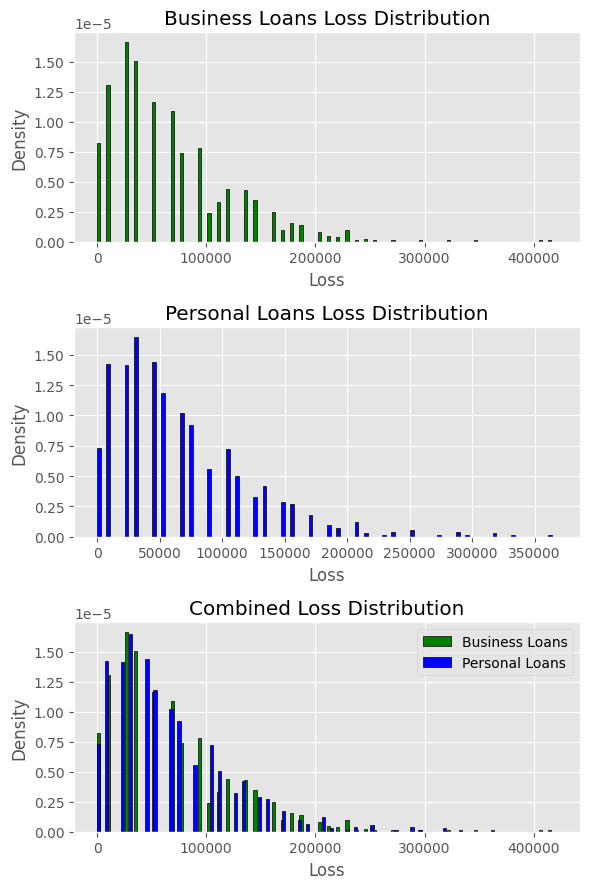

Expected Loss (EL): 137165.00€

Unexpected Loss (UL): 104937.58€

Value at Risk (VaR) 99%: 480042.50€

Value at Risk (VaR) 95%: 342050.00€



In [309]:
# Setting the style
plt.style.use('ggplot')

# Creating subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 9))

# Plotting for business loans
axes[0].hist(losses_business, bins=50, density=True, alpha=1, color='green', edgecolor='black', linewidth=0.5, width=3000)
axes[0].set_title('Business Loans Loss Distribution')
axes[0].set_xlabel('Loss')
axes[0].set_ylabel('Density')

# Plotting for personal loans
axes[1].hist(losses_personal, bins=50, density=True, alpha=1, color='blue', edgecolor='black', linewidth=0.5, width=3000)
axes[1].set_title('Personal Loans Loss Distribution')
axes[1].set_xlabel('Loss')
axes[1].set_ylabel('Density')

# Plotting for combined loans
axes[2].hist(losses_business, bins=50, density=True, alpha=1, color='green', label='Business Loans', edgecolor='black', linewidth=0.5, width=3000)
axes[2].hist(losses_personal, bins=50, density=True, alpha=1, color='blue', label='Personal Loans', edgecolor='black', linewidth=0.5, width=3000)
axes[2].set_title('Combined Loss Distribution')
axes[2].set_xlabel('Loss')
axes[2].set_ylabel('Density')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()
# Combine losses for calculations
total_losses = losses_personal + losses_business

# Expected Loss (EL)
EL = np.mean(total_losses)
print(f"Expected Loss (EL): {EL:.2f}€\n")

# Unexpected Loss (UL)
UL = np.std(total_losses)
print(f"Unexpected Loss (UL): {UL:.2f}€\n")

# Value at Risk (VaR) 99%
VaR_99 = np.percentile(total_losses, 99)
print(f"Value at Risk (VaR) 99%: {VaR_99:.2f}€\n")

# Value at Risk (VaR) 95%
VaR_95 = np.percentile(total_losses, 95)
print(f"Value at Risk (VaR) 95%: {VaR_95:.2f}€\n")